In [24]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import quantstats as qs
import os
import warnings

In [3]:
base_dir = os.getcwd()
print(base_dir)
file_path = os.path.abspath(os.path.join(base_dir, '..', 'data'))
print(file_path)

c:\Users\matth\Desktop\clean_code_2024-09-29\backtesting
c:\Users\matth\Desktop\clean_code_2024-09-29\data


In [5]:
stock_data = pd.read_parquet(file_path+'\\stock_price_data\\all_data_processed_2024-09-28_after_1990.parquet')
display(stock_data.info())
display(stock_data.tail())

In [7]:
def select_data_subset(input_dataframe, std_dev_day_range='all', reg_day_range='all', ticker_subset='all', price_vars_to_exclude='none', start_date='none'):
    """
    Selects a subset of stock data based on a variety of factors.

    Args:
        input_dataframe (pandas dataframe, required): DataFrame with stock data.
        std_dev_day_range (str, list, optional): Leave as 'all' to include everything, give an int or a list of ints to select only std_devs over that/those periods. Defaults to 'all'.
        reg_day_range (list, optional): Leave as 'all' to include everything, give an int or a list of ints to select only reg values (intercept and coeffs) over that/those periods. Defaults to 'all'.
        ticker_subset (list, optional): Leave as 'all' to include all tickers, or give a list of ticker(s) to keep. Defaults to 'all'.
        price_vars_to_exclude (list, optional): Leave as 'none' to include all price vars, or give a list of price variables to exclude. Defaults to 'none'.
        start_date (str, optional): The date before which you don't want data, in the format 'YYYY-MM-DD'. Defaults to 'none'.

    Returns:
        pandas dataframe: Filtered DataFrame based on the specified criteria.
    """

    # filter date
    if start_date != 'none':
        return_df = input_dataframe[input_dataframe.index > start_date]
    else:
        return_df = input_dataframe
    
    return_cols = list(return_df.columns)

    # filter tickers
    if ticker_subset != 'all':
        # print(return_cols)
        return_cols = list(x for x in return_cols if x[1] in (ticker_subset+['']) )
    
    # exclude price vars
    if price_vars_to_exclude != 'none':
        return_cols = list({x for x in return_cols if x[0] not in price_vars_to_exclude})
    
    # filter std dev day ranges
    if std_dev_day_range != 'all':
        std_dev_day_range = tuple(str(x) for x in std_dev_day_range)
        return_cols = list(
            set(return_cols)
            - set( list(x for x in return_cols if ( x[0].startswith('Std_Dev') and (not (x[0].endswith(std_dev_day_range))) )) )
            )


    # filter regression day ranges
    if reg_day_range != 'all':
        print()
        bad_reg_cols = [
            x for x in return_cols 
            if (x[0].split('_')[0] == 'Intercept' or 
                (len(x[0].split('_')) > 1 and x[0].split('_')[-2] == 'Coeff') )
                ]
        # print(bad_reg_cols)
        # bad_reg_cols = {x for x in bad_reg_cols if any(a in x for a in reg_day_range)}
        # print({x[0] for x in bad_reg_cols})
        # print(bad_reg_cols[0:10])
        bad_reg_cols = {x for x in bad_reg_cols if not any(str(a) in x[0] for a in reg_day_range)}
        # print({x[0] for x in bad_reg_cols})
        return_cols = list(set(return_cols) - set(bad_reg_cols))

    #     reg_day_range = tuple(str(x) for x in reg_day_range)
    #     print(return_cols[-10:])
    #     return_cols = list(
    #         set(return_cols)
    #         - set( x for x in return_cols if 
    #             #   ((x[0].startswith('Intercept_') or x[0].split('_')[-2]=='Coeff') and (not x[0].endswith(reg_day_range))))
    #               ((x[0].split('_')[0]=='Intercept' or x[0].split('_')[-2]=='Coeff') and (not x[0].endswith(reg_day_range))))
    #     )

    # filter regression day ranges
    # if reg_day_range != 'all':
    #     reg_day_range = tuple(str(x) for x in reg_day_range)
    #     print(return_cols[-10:])
    #     return_cols = list(
    #         set(return_cols)
    #         - set( x for x in return_cols if 
    #             #   ((x[0].startswith('Intercept_') or x[0].split('_')[-2]=='Coeff') and (not x[0].endswith(reg_day_range))))
    #               ((x[0].split('_')[0]=='Intercept' or x[0].split('_')[-2]=='Coeff') and (not x[0].endswith(reg_day_range))))
    #     )
    
    if not((ticker_subset == 'all') and (price_vars_to_exclude =='none') and (std_dev_day_range=='all') and (reg_day_range=='all')):
        return_df = return_df[return_cols]

    return(return_df)


In [8]:
def add_lin_reg_prediction(df, reg_range, predict_target_day=0, new_multiindex_col_name=None):
    """adds a linear regression prediction using existing coefficients and intercepts

    Args:
        df (dataframe, required): the dataframe that holds the data
        reg_range (int, required): one of the ranges that regressions exist over in the dataframe
        predict_target (int, optional): the target of the prediction relative to the column. 0 will be that day, 5 will be 5 trading days into the future. Defaults to 0.
        new_multiindex_col_name (str, optional): add a string you want as the multi index title in index 0 of the column name, or leave as None to return non-multi index dataframe. Defaults to None.
    
    Returns:
        pandas dataframe with only the regression prediction values
    """

    # the column that holds the intercept for the regression
    intercept_col = 'Intercept_'+str(reg_range)

    # a list of columns with the coefficients
    coeff_cols = list({x[0] for x in df.columns if(
        x[0].endswith(str(reg_range)) and
        x[0].split('_')[-2]=='Coeff'
    )})

    # a list of columns with what the coeffients are to be multiplied by
    predictor_cols = list({ ('_'.join(x.split('_')[0:-2])) for x in coeff_cols})

    coeff_cols_dict = {}
    for coeff in coeff_cols:
        # get predictor name
        predictor_name = '_'.join(coeff.split('_')[:-2])
        
        # checks if there is an error in the naming system- better to throw an error than have wrong data
        if predictor_name in predictor_cols:
            coeff_cols_dict[predictor_name] = coeff
        else: 
            exit("column names are fucked up, a predictor_col doesn't")
    
    del(coeff_cols)

    # intercept
    return_df = df.xs(intercept_col, axis=1,level=0)

    # plus coefficient* value for each coeficient value pair (for multivar regressions)
    for p_col in predictor_cols:
        return_df = return_df + (df.xs(p_col,axis=1,level=0).values *df.xs(coeff_cols_dict[p_col], axis=1, level =0))
    
    if new_multiindex_col_name == None:
        return(return_df.apply(pd.to_numeric, errors='coerce'))
    else: 
        new_columns = pd.MultiIndex.from_product([[new_multiindex_col_name], return_df.columns])
        return_df.columns= new_columns
        return(return_df.apply(pd.to_numeric, errors='coerce'))

In [9]:
def add_price_diff_metric(df, actual_val_col, theo_val_col, std_dev_col, new_multiindex_col_name=None):
    """returns dataframe with difference between theoretical value and actual price in terms of a value

    Args:
        df (pandas dataframe): source dataframe
        actual_val_col (str): the name of the column of the actual price value eg 'Adj_Close'"date_numbers copy.py"
        theo_val_vol (str): the name of the column of the predicted theoretical price 
        std_dev_col (str): the name of the column of standard deviation you want the difference in terms of
        new_multiindex_col_name (str, optional): add a string you want as the multi index title in index 0 of the column name, or leave as None to return non-multi index dataframe. Defaults to None.

    """
    

    return_df = df.xs(theo_val_col, axis=1, level=0)
    return_df = return_df - df.xs(actual_val_col, axis=1, level=0)
    return_df = return_df/ df.xs(std_dev_col, axis=1, level=0)

    if new_multiindex_col_name == None:
        return(return_df)
    else: 
        new_columns = pd.MultiIndex.from_product([[new_multiindex_col_name], return_df.columns])
        return_df.columns = new_columns
        return(return_df)


In [10]:
stock_data = select_data_subset(
    input_dataframe=stock_data,
    std_dev_day_range=[30, 60],
    reg_day_range=[30, 60],
    # ticker_subset=['AAPL', 'CMI', 'SLB'],
    price_vars_to_exclude=['Open','Close','High','Low'],
    start_date='1993-06-01'
)
# print(list({x[0] for x in stock_data.columns}))
display(stock_data)


Intercept_60 Dates_Numeric_Coeff_60 Std_Dev_30            \
                  TRINL                   BYSI       SNDL        CP   
Date                                                                  
1993-06-02          NaN                    NaN        NaN  0.017427   
1993-06-03          NaN                    NaN        NaN  0.016866   
1993-06-04          NaN                    NaN        NaN  0.016764   
1993-06-07          NaN                    NaN        NaN  0.016473   
1993-06-08          NaN                    NaN        NaN  0.016158   
...                 ...                    ...        ...       ...   
2024-09-23    26.605126              -0.007901   0.082047  3.100748   
2024-09-24    26.585546              -0.007899   0.083112  3.009594   
2024-09-25    26.557112              -0.007896   0.082527  2.881094   
2024-09-26    26.544438              -0.007895   0.082624  2.702917   
2024-09-27    26.526051              -0.007893   0.081352  2.536979   

           Std_Dev_60 Dates_Numeric_Coeff_60 Intercept_60 Std_Dev_30  \
                  AIZ                  PDYNW          OBT        APA   
Date                                                                   
1993-06-02        NaN                    NaN          NaN   0.211861   
1993-06-03        NaN                    NaN          NaN   0.197398   
1993-06-04        NaN                    NaN          NaN   0.236738   
1993-06-07        NaN                    NaN          NaN   0.260936   
1993-06-08        NaN                    NaN          NaN   0.295453   
...               ...                    ...          ...        ...   
2024-09-23  11.792004              -0.000444    15.599880   2.030414   
2024-09-24  11.892809              -0.000443    15.573656   2.032415   
2024-09-25  11.932208              -0.000442    15.561657   2.003489   
2024-09-26  11.946105              -0.000442    15.531068   1.998308   
2024-09-27  11.970242              -0.000441    15.510440   2.041791   

           Dates_Numeric_Coeff_30 Intercept_30  ...             Volume  \
                              GEL          WCC  ...      GLPG     GIPR   
Date                                            ...                      
1993-06-02                    NaN          NaN  ...       NaN      NaN   
1993-06-03                    NaN          NaN  ...       NaN      NaN   
1993-06-04                    NaN          NaN  ...       NaN      NaN   
1993-06-07                    NaN          NaN  ...       NaN      NaN   
1993-06-08                    NaN          NaN  ...       NaN      NaN   
...                           ...          ...  ...       ...      ...   
2024-09-23               0.001072    22.623596  ...  5.305274  15700.0   
2024-09-24               0.001071    22.632456  ...  5.163056  25900.0   
2024-09-25               0.001071    22.643318  ...  5.020264  10300.0   
2024-09-26               0.001072    22.648018  ...  4.890177  38000.0   
2024-09-27               0.001072    22.660433  ...  4.722706  19900.0   

           Dates_Numeric_Coeff_60 Dates_Numeric_Coeff_30    Market_Cap  \
                             AVNW                   SBGI          WTFC   
Date                                                                     
1993-06-02              -0.009436                    NaN           NaN   
1993-06-03              -0.009339                    NaN           NaN   
1993-06-04              -0.009203                    NaN           NaN   
1993-06-07              -0.009061                    NaN           NaN   
1993-06-08              -0.008931                    NaN           NaN   
...                           ...                    ...           ...   
2024-09-23              -0.002040               0.000654  7.196008e+09   
2024-09-24              -0.002047               0.000657  7.159433e+09   
2024-09-25              -0.002054               0.000664  7.051037e+09   
2024-09-26              -0.002061               0.000670  7.119533e+09   
2024-09-

In [11]:
magic_number = str(30)
theo_var = 'Lin_Reg_60_Pred_0'#'Lin_Reg_Pred_' + magic_number
std_dev_var = 'Std_Dev_30' #'Std_Dev_' + magic_number + '_Day'
price_diff_var = 'delta_60pred_by_30std'#'Price_Diff_' + magic_number
how_old_to_sell = 120
how_many_poss = 30
del(magic_number)

class Position:
    def __init__(self, date_opened, ticker, shares):
        self.date_opened = date_opened
        self.ticker = ticker
        self.shares = shares
        self.cost_basis = shares*stock_data.at[date_opened,('Adj_Close',ticker)]
        self._current_value = shares*stock_data.at[date_opened,('Adj_Close',ticker)]
        self._current_theo = shares*stock_data.at[date_opened,(theo_var,ticker)]
        self._current_std_dev = shares*stock_data.at[date_opened,(std_dev_var,ticker)]
        self._current_price_diff = stock_data.at[date_opened,(price_diff_var,ticker)]
        self._last_date_checked = date_opened

    def __repr__(self):
        return (f"Position(date_opened={self.date_opened}, ticker='{self.ticker}', "
                f"shares={self.shares}, cost_basis={self.cost_basis}, "
                f"current_value={self._current_value}, "
                f"current_theo={self._current_theo}, "
                f"current_std_dev={self._current_std_dev}, "
                f"current_price_diff={self._current_price_diff}),"
                f"last_date_checked={self._last_date_checked}")

    def get_ticker(self):
        return(self.ticker)
    
    def days_old(self, date:str):
        """returns the number of days old a position is

        Args:
            date (str): date formated 'YYYY-MM-DD'
        """
        if type(self.date_opened) == str:
            opened = datetime.datetime.strptime(self.date_opened, '%Y-%m-%d').date()
        else:
            opened = self.date_opened
        if type(date)==str:
            current = datetime.datetime.strptime(date, '%Y-%m-%d').date()
        else:
            current = date
        return((current-opened).days)
    
    def __refresh__(self,current_date):
        self._last_date_checked = current_date
        self._current_value = self.shares*stock_data.at[current_date,('Adj_Close',self.ticker)]
        self._current_theo = stock_data.at[current_date,(theo_var, self.ticker)]
        self._current_std_dev = stock_data.at[current_date,(theo_var, self.ticker)]
        self._current_price_diff = stock_data.at[current_date,(price_diff_var, self.ticker)]
        # recalculate current_value as well as all other values that change over time,
        pass

    def get_current_value(self, current_date):
        self.__refresh__(current_date=current_date)
        return(self._current_value)
    
    def get_current_theo(self, current_date):
        self.__refresh__(current_date=current_date)
        return(self._current_theo)
    
    def get_current_std_dev(self, current_date):
        self.__refresh__(current_date=current_date)
        return(self._current_std_dev)

    def get_current_price_diff(self, current_date):
        self.__refresh__(current_date=current_date)
        return(self._current_price_diff)


In [12]:
class Portfolio:
    def __init__(self, cash: float, date, trading_cost =0.005):
        """create portfolio object

        Args:
            cash (float): starting amount of cash in account
            date (_type_): starting date
            trading_cost (float, optional): cost of trading- each time we transact, we lose this amount. Defaults to 0.005.
        """
        self.position_df = pd.DataFrame(columns=['Position', 'Exposure', 'Value', 'Date_Opened', 'Days_Old'])
        self.position_df.index.name = 'Ticker'
        # Ensure 'Value' is explicitly set to float type
        self.position_df.loc['cash_position'] = ['N/A', 'N/A', float(cash), date, 0]  # Cast cash to float
        self.position_df = self.position_df.astype({'Value': 'float64'})  # Ensure Value column remains float
        self._last_date_checked = date
        self.trading_cost = trading_cost
        # log portfolio opening
        # logger.info(f'Portfolio opened on {date}')
    
    # def __repr__(self):
    #     returnString = f"Current Portfolio Value: {self.get_portfolio_value(self._last_date_checked)}\n"
    #     returnString += f"Cash: {self.position_df.loc['cash_position', 'Value']}\n"
    #     for pos in self.position_df['Position']:
    #         returnString += repr(pos)
    #     return returnString
        
    def get_cash(self):
        """returns size of cash_position
        """
        return(self.position_df.at['cash_position','Value'])

    def get_exposure(self):
        exposure = self.position_df['Value'].iloc[1:].sum()
        return(exposure)

    def position_count(self):
        return(len(self.position_df.index)-1)
    
    def open_position(self, position):
        # Assuming position has attributes `cost_basis`, `get_ticker()`, and `date_opened`
        if position.cost_basis > self.position_df.loc['cash_position', 'Value']:
            print('Position not opened; too expensive')
            print(f"Available cash: {self.position_df.loc['cash_position', 'Value']}\nPosition cost: {position.cost_basis}")
        else:
            # Explicit cast to ensure correct dtype when modifying Value
            self.position_df.loc['cash_position', 'Value'] = float(self.position_df.loc['cash_position', 'Value']) - (position.cost_basis * (1+self.trading_cost))
            # Add new row for the position
            self.position_df.loc[position.get_ticker()] = [position, position.shares, position.cost_basis, position.date_opened, 0]
            # log purchase
    
    def close_position(self, ticker: str, current_date: str):
        """close a currently open position"""
        self._last_date_checked = current_date
        if ticker == 'cash_position':
            print('Cannot sell cash position')
        else:
            position_value = self.position_df.loc[ticker, 'Position'].get_current_value(current_date)
            self.position_df.loc['cash_position', 'Value'] += (position_value * (1-self.trading_cost))
            self.position_df.drop(index=ticker, inplace=True)
            # log sale
    
    def get_portfolio_value(self, date):
        """gets the value of all the positions in the portfolio on the given date"""
        self.refresh_position_df(date)
        self._last_date_checked = date
        value = 0
        for ticker in self.position_df.index:
            value += self.position_df.loc[ticker, 'Value']
        return value
    
    def refresh_position_df(self, date):
        self._last_date_checked = date
        for ticker in self.position_df.index[1:]:  # Skipping the cash position
            self.position_df.loc[ticker, 'Value'] = self.position_df.loc[ticker, 'Position'].get_current_value(date)
            self.position_df.loc[ticker,'Days_Old'] = self.position_df.loc[ticker, 'Position'].days_old(date)

    def to_string(self, date: str):
        """returns a string summarizing portfolio's value"""
        self.refresh_position_df(date)
        return_string = f"Current Portfolio Value: {self.get_portfolio_value(date)}\n"
        return_string += f"Cash: {self.position_df.loc['cash_position', 'Value']}\n"
        for ticker in self.position_df.index[1:]:
            return_string += repr(self.position_df.loc[ticker, 'Position']) +'\n'
        return return_string


In [13]:
def best_on_date(stock_data:pd.DataFrame,date:str,metric:str,abs_val:bool=True,how_many:int=1, max_or_min = 'max',exclude_extremes=True, min_trading_volume=10000, min_trading_volume_value=100000, size_categories=['mega','large','mid','small','micro'], min_market_cap=0):
    """gets the ticker(s) of the best stock or stocks on a specific
    date according to the numerical value of either a specific metric,
    or the absolute value of a specific metric. If there is not enough tickers with data then the
    return value will be None and a warning will be printed and logged

    Args:
        stock_data (pd.DataFrame): the dataframe to use for reference
        date (str): date in the format of 'YYYY-MM-DD'
        metric (str): the name of the column to be used for evaluation
        abs_val (bool, optional): do you want the highest values in the column, or the values furthest from 0. Defaults to True.
        how_many (int, optional): top __ ticker(s). Defaults to 1.
    """

    # takes a slice of dataframe for current date with .xs(date)
    # unstack if because .xs puts it in long format
    # transpose so tickers are the index column
    date_slice = stock_data.xs(date).unstack().transpose()

    # numeric_cols = date_slice.select_dtypes(include=['float', 'int']).columns
    # date_slice[numeric_cols] = date_slice[numeric_cols].apply(pd.to_numeric, errors='coerce')
    # date_slice[metric] = pd.to_numeric(date_slice[metric], errors='coerce')
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        warnings.simplefilter("ignore", category=FutureWarning)
        date_slice[metric] = pd.to_numeric(date_slice[metric], errors='coerce')


    # simplify to just relevant data and drop na columns so we don't return useless data
    date_slice = date_slice[date_slice['Market_Cap']>min_market_cap]
    date_slice = date_slice[date_slice['Size_Category'].isin(size_categories)]
    date_slice = date_slice[date_slice['Volume']>min_trading_volume]
    date_slice = date_slice[date_slice['Volume_Value']>min_trading_volume_value]
    date_slice = date_slice.filter(items=['Adj_Close', 'Volume', metric]).dropna()
    # date_slice = date_slice.query(abs(metric)<100)# excludes extremes
    date_slice = date_slice[np.abs(date_slice[metric])<50]
    
    

    

    # if there is not enough data to return the number of tickers wanted, returns 
    if len(date_slice.index)<how_many:
        warningString = f"Warning: not enough data on {date} to run best_on_date. There is only {len(date_slice.index)} non-NaN values in {metric} but you want the top {how_many}. Returning {None}"
        warnings.warn(warningString)
        # logger.warning(warningString)
        return(None)
    else:
        if max_or_min =='max':
            if(abs_val):
                # gets the id (Tickers) of the 2 highest absolute value for price_diff_var
                max_tickers = abs(date_slice).nlargest(how_many,[metric]).index.tolist()
            else:
                # gets the id (Tickers) of the 2 highest value for price_diff_var
                max_tickers = date_slice.nlargest(how_many,[metric]).index.tolist()
            return(max_tickers)
        if max_or_min == 'min':
            if(abs_val):
                # gets the id (Tickers) of the 2 highest absolute value for price_diff_var
                min_tickers = abs(date_slice).nsmallest(how_many,[metric]).index.tolist()
            else:
                # gets the id (Tickers) of the 2 highest value for price_diff_var
                min_tickers = date_slice.nsmallest(how_many,[metric]).index.tolist()
            return(min_tickers)


In [14]:
pred_df_30 = add_lin_reg_prediction(stock_data, 30, new_multiindex_col_name='Lin_Reg_30_Pred_0')
pred_df_60 = add_lin_reg_prediction(stock_data, 60, new_multiindex_col_name='Lin_Reg_60_Pred_0')

stock_data = pd.concat([stock_data, pred_df_30, pred_df_60],axis=1)

stock_data = pd.concat([ stock_data, 
                           add_price_diff_metric(stock_data, 'Adj_Close','Lin_Reg_60_Pred_0', 'Std_Dev_30', 'delta_60pred_by_30std')
                           ], axis=1)

# adds volume value
price_df = stock_data.xs('Adj_Close',axis=1,level=0)
volume_df = stock_data.xs('Volume',axis=1,level=0)
volume_value_df = price_df*volume_df
new_columns = pd.MultiIndex.from_product([['Volume_Value'], volume_value_df.columns])
volume_value_df.columns = new_columns
display(volume_value_df)
stock_data = pd.concat([stock_data,volume_value_df],axis=1)


Volume_Value                                             \
                       A            AA           AACG          AACT   
Date                                                                  
1993-06-02           NaN  6.823729e+06            NaN           NaN   
1993-06-03           NaN  3.398073e+06            NaN           NaN   
1993-06-04           NaN  1.102137e+07            NaN           NaN   
1993-06-07           NaN  7.812339e+06            NaN           NaN   
1993-06-08           NaN  7.436787e+06            NaN           NaN   
...                  ...           ...            ...           ...   
2024-09-23  3.046723e+08  1.426227e+08  120518.999088  5.162400e+05   
2024-09-24  2.738233e+08  3.558686e+08   67388.000709  5.091510e+05   
2024-09-25  2.004171e+08  1.918181e+08   45187.001181  2.841480e+06   
2024-09-26  3.154470e+08  3.738474e+08   17280.000687  1.018302e+06   
2024-09-27  3.276568e+08  2.210587e+08   19053.000498  2.707500e+04   

                                                                     \
                     AADI           AAL           AAM          AAME   
Date                                                                  
1993-06-02            NaN           NaN           NaN   4366.726875   
1993-06-03            NaN           NaN           NaN   5458.408594   
1993-06-04            NaN           NaN           NaN   1310.018063   
1993-06-07            NaN           NaN           NaN   3907.071352   
1993-06-08            NaN           NaN           NaN   2344.242811   
...                   ...           ...           ...           ...   
2024-09-23  146496.997440  3.380204e+08  1.595403e+06  13272.000360   
2024-09-24  350972.997344  3.250894e+08  1.540770e+05   4452.000093   
2024-09-25  165489.997923  3.207281e+08  2.504747e+06   8735.999680   
2024-09-26  159102.997220  7.351478e+08  1.625424e+07  21735.000193   
2024-09-27  156329.995751  3.555694e+08  5.376371e+06  18983.999407   

                                        ...                              \
                     AAN          AAOI  ...           ZTS          ZUMZ   
Date                                    ...                               
1993-06-02           NaN           NaN  ...           NaN           NaN   
1993-06-03           NaN           NaN  ...           NaN           NaN   
1993-06-04           NaN           NaN  ...           NaN           NaN   
1993-06-07           NaN           NaN  ...           NaN           NaN   
1993-06-08           NaN           NaN  ...           NaN           NaN   
...                  ...           ...  ...           ...           ...   
2024-09-23  1.170984e+07  2.486652e+07  ...  2.547064e+08  7.684122e+06   
2024-09-24  1.289491e+07  8.845889e+07  ...  3.961154e+08  5.761600e+06   
2024-09-25  1.482434e+07  3.261021e+07  ...  3.651136e+08  5.397345e+06   
2024-09-26  2.526958e+07  3.654812e+07  ...  3.032372e+08  5.384998e+06   
2024-09-27  1.432628e+07  3.725344e+07  ...  2.617662e+08  5.775000e+06   

                                                                     \
                     ZUO          ZURA           ZVIA          ZVRA   
Date                                                                  
1993-06-02           NaN           NaN            NaN           NaN   
1993-06-03           NaN           NaN            NaN           NaN   
1993-06-04           NaN           NaN            NaN           NaN   
1993-06-07           NaN           NaN            NaN           NaN   
1993-06-08           NaN           NaN            NaN           NaN   
...                  ...           ...            ...           ...   
2024-09-23  9.765792e+06  5.381460e+06  121220.002627  1.818669e+07   
2024-09-24  6.546320e+06  1.614000e+06  130540.006399  2.047156e+07   
2024-09-25  9.717246e+06  7.163120e+05  330747.005129  1.784845e+07   
2024-09-26  8.135578e+06  7.189670e+05  176903.993511  6.633825e+06   
2024-09-27  1.135437e+07  1.600731e+06   80597.9

In [15]:
print(list({x[0] for x in stock_data.columns}))
print(stock_data.info())

['Std_Dev_60', 'Volume', 'Intercept_30', 'Adj_Close', 'Std_Dev_30', 'Market_Cap', 'Dates_Numeric_Coeff_60', 'Dates_Numeric_Coeff_30', 'Dates_Numeric', 'Lin_Reg_30_Pred_0', 'Lin_Reg_60_Pred_0', 'Volume_Value', 'Size_Category', 'Intercept_60', 'delta_60pred_by_30std']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7888 entries, 1993-06-02 to 2024-09-27
Columns: 85977 entries, ('Intercept_60', 'TRINL') to ('Volume_Value', 'ZYXI')
dtypes: float64(80325), int64(30), object(5622)
memory usage: 5.1+ GB
None


In [16]:
list_of_dates = stock_data.index
list_of_dates

DatetimeIndex(['1993-06-02', '1993-06-03', '1993-06-04', '1993-06-07',
               '1993-06-08', '1993-06-09', '1993-06-10', '1993-06-11',
               '1993-06-14', '1993-06-15',
               ...
               '2024-09-16', '2024-09-17', '2024-09-18', '2024-09-19',
               '2024-09-20', '2024-09-23', '2024-09-24', '2024-09-25',
               '2024-09-26', '2024-09-27'],
              dtype='datetime64[ns]', name='Date', length=7888, freq=None)

In [17]:
start_date_index = 401
print(list_of_dates[start_date_index])

1995-01-03 00:00:00


In [18]:
portfolio_starting_capital = 10000
my_portfolio = Portfolio(portfolio_starting_capital,list_of_dates[start_date_index],trading_cost=0.01)
print(my_portfolio.position_df)

              Position Exposure    Value Date_Opened  Days_Old
Ticker                                                        
cash_position      N/A      N/A  10000.0  1995-01-03         0


In [19]:
how_old_to_sell = 135

In [20]:
print(f"std_dev_var: {std_dev_var}")
print(f"theo_var: {theo_var}")
print(f"price_diff_var: {price_diff_var}")
print(f"how_old_to_sell: {how_old_to_sell}")
print(f"how_many_poss: {how_many_poss}")

std_dev_var: Std_Dev_30
theo_var: Lin_Reg_60_Pred_0
price_diff_var: delta_60pred_by_30std
how_old_to_sell: 135
how_many_poss: 30


In [22]:
historical_performance = pd.DataFrame(columns=['Portfolio_Value'])
historical_performance.index.name = 'Date'

In [25]:
how_many_poss = how_many_poss
how_many_total = how_many_poss*2
how_many_rev = how_many_poss
how_many_mom = how_many_poss

how_old_to_sell = how_old_to_sell
short_position_wiggle_room = 1.2
for date in list_of_dates[start_date_index:]:
    clear_output(wait=True)
    my_portfolio.refresh_position_df(date)
    # any positions to sell
    tickers_to_sell = my_portfolio.position_df[my_portfolio.position_df['Days_Old'] >= how_old_to_sell].index.tolist()
    historical_performance.loc[date] = my_portfolio.get_portfolio_value(date)
    if (len(tickers_to_sell)>0):
        print(f"cash on hand: {my_portfolio.get_cash()}")
        print(f"tickers_to_sell: {tickers_to_sell}")
        for tts in tickers_to_sell:
            # historical_trades.loc[date] = [tts, my_portfolio.position_df.loc[tts,'Exposure'], None, my_portfolio.position_df.loc[tts,'Position'].get_current_value(date)]
            my_portfolio.close_position(tts,date)
        tickers_to_sell=0
        
    if(my_portfolio.position_count()<how_many_total):
        positions_we_want_rev = best_on_date(stock_data=stock_data,date=date,metric=price_diff_var,abs_val=False,how_many=how_many_rev,max_or_min='max',size_categories=['mid'], min_market_cap=100000)
        positions_we_want_mom = best_on_date(stock_data=stock_data,date=date,metric=price_diff_var,abs_val=False,how_many=how_many_mom,max_or_min='min',size_categories=['micro'], min_market_cap=100000)
        # (position_size cash - (value of short positions)*(short_position_wiggle_room)) / how many positions we plan on opening
        position_size = (my_portfolio.get_cash() + my_portfolio.position_df.query('Value < 0')['Value'].sum()*short_position_wiggle_room) / (how_many_total-my_portfolio.position_count())
        print(f"position_size: {position_size}")
        print(f"portfolio_value: {my_portfolio.get_portfolio_value(date)}")
        print(f"positions_we_want_mom: {positions_we_want_mom}")
        print(f"positions_we_want_rev: {positions_we_want_rev}")
        positions_we_want = positions_we_want_mom+positions_we_want_rev
        # open positions
        # get data on the positions we want
        relevant_data_rev = stock_data.xs(date).unstack().transpose().loc[positions_we_want_rev,['Adj_Close','Market_Cap','Size_Category',price_diff_var,std_dev_var,theo_var,'Volume','Volume_Value']]
        relevant_data_mom = stock_data.xs(date).unstack().transpose().loc[positions_we_want_mom,['Adj_Close','Market_Cap','Size_Category',price_diff_var,std_dev_var,theo_var,'Volume','Volume_Value']]
        relevant_data_rev['Strategy'] = 'Mean_Reversion'
        relevant_data_mom['Strategy'] = 'Momentum'
        relevant_data = pd.concat([relevant_data_mom,relevant_data_rev],axis=0)
        for ticker in positions_we_want:
            # last part makes desired shares negative if we expect stock to go down
                # *1.03 gives us wiggle room for slippage
            if relevant_data.loc[ticker,'Strategy']=='Mean_Reversion':
                relevant_data.loc[ticker,'Desired_Shares'] = (position_size//(relevant_data.at[ticker,'Adj_Close']*1.03)) * (relevant_data.loc[ticker, price_diff_var]/abs(relevant_data.loc[ticker, price_diff_var]))
                # make sure we're not trading more than 3% of the trading volume 
                relevant_data['Desired_Shares'] = np.minimum(abs(relevant_data['Desired_Shares']), 0.08 * relevant_data['Volume']) * (relevant_data['Desired_Shares']/abs(relevant_data['Desired_Shares'])) # last part accounts for shorting

                # make it momentum instead of mean reversion
                # relevant_data.loc[ticker,'Desired_Shares'] *= -1
                relevant_data['Desired_Shares'] = relevant_data['Desired_Shares'].fillna(0)


                # historical_trades.loc[date] = [tts, my_portfolio.position_df.loc[tts,'Exposure'], my_portfolio.position_df.loc[tts,'Position'].get_current_value(date),None]
                my_portfolio.open_position(Position(date,ticker, relevant_data.at[ticker,'Desired_Shares']))

            
            if relevant_data.loc[ticker,'Strategy']=='Momentum':
                relevant_data.loc[ticker,'Desired_Shares'] = (position_size//(relevant_data.at[ticker,'Adj_Close']*1.03)) * (relevant_data.loc[ticker, price_diff_var]/abs(relevant_data.loc[ticker, price_diff_var]))
                # make sure we're not trading more than 3% of the trading volume 
                relevant_data['Desired_Shares'] = np.minimum(abs(relevant_data['Desired_Shares']), 0.08 * relevant_data['Volume']) * (relevant_data['Desired_Shares']/abs(relevant_data['Desired_Shares'])) # last part accounts for shorting

                # make it momentum instead of mean reversion
                relevant_data.loc[ticker,'Desired_Shares'] *= -1
                relevant_data['Desired_Shares'] = relevant_data['Desired_Shares'].fillna(0)


                # historical_trades.loc[date] = [tts, my_portfolio.position_df.loc[tts,'Exposure'], my_portfolio.position_df.loc[tts,'Position'].get_current_value(date),None]
                my_portfolio.open_position(Position(date,ticker, relevant_data.at[ticker,'Desired_Shares']))

        display(relevant_data)
        print(date)
    # historical_performance.loc[date] = my_portfolio.get_portfolio_value(date)
        
    # desired_shares = my_portfolio.cash/2//relevant_data.at['JBHT','Adj_Close']
    # my_portfolio.open_position(Position(date,'JBHT',desired_shares))


cash on hand: 28741.945100672576
tickers_to_sell: ['CISO', 'IDAI', 'WBUY', 'CTRM', 'VANI', 'LIFW', 'TPST', 'SNPX', 'AVTX', 'BENF', 'OCUP', 'BIOR', 'IVP', 'TECX', 'ATOS', 'GCTK', 'ITRM', 'TRVN', 'WORX', 'VTGN', 'DARE', 'USEG', 'ATYR', 'INVO', 'KAVL', 'LQR', 'SEER', 'TGL', 'HUBC', 'TIL', 'PWSC', 'ROKU', 'DBX', 'MLCO', 'IMVT', 'TDOC', 'NYCB', 'LBTYK', 'NYT', 'INST', 'FIVN', 'LBTYA', 'TDC', 'HUBG', 'SAM', 'RAMP', 'IONS', 'SNDR', 'MSGS', 'CNXC', 'BBIO', 'QDEL', 'SPT', 'LSTR', 'ESTC', 'DV', 'FR', 'IART', 'USM', 'APLS']
position_size: 9956.166256110115
portfolio_value: 597369.9753666068
positions_we_want_mom: ['GMM', 'BHIL', 'DARE', 'RDHL', 'HUBC', 'OPHC', 'INM', 'HYFM', 'ITRM', 'XCUR', 'APTO', 'HOLO', 'MTC', 'NDRA', 'ADD', 'BLNK', 'EZGO', 'VS', 'XRTX', 'TARA', 'FBRX', 'EKSO', 'NAAS', 'ATYR', 'INVO', 'BNRG', 'ALZN', 'RIME', 'CYN', 'SNPX']
positions_we_want_rev: ['ESTC', 'MLCO', 'WBA', 'CELH', 'BZ', 'SMPL', 'BVN', 'BBWI', 'BIRK', 'KSS', 'AAP', 'SBSW', 'ELF', 'FIVE', 'VECO', 'DDS', 'TX', 'AY', 

C:\Users\matth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\matth\AppData\Local\Temp\ipykernel_9804\4286467674.py:63: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relevant_data['Desired_Shares'] = relevant_data['Desired_Shares'].fillna(0)
C:\Users\matth\AppData\Local\Temp\ipykernel_9804\4286467674.py:63: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downca

,Adj_Close,Market_Cap,Size_Category,delta_60pred_by_30std,Std_Dev_30,Lin_Reg_60_Pred_0,Volume,Volume_Value,Strategy,Desired_Shares
GMM,0.9,25690949.319422,micro,-48.660519,0.038296,-0.963497,118900.0,107009.997165,Momentum,9512.0
BHIL,6.04,36962323.366556,micro,-46.698816,0.261391,-6.166628,17000.0,102679.999352,Momentum,1360.0
DARE,3.58,30595968.147964,micro,-45.353741,0.18026,-4.595467,60900.0,218021.995354,Momentum,2700.0
RDHL,8.5,10884590.0,micro,-45.140321,2.403819,-100.009149,21400.0,181900.0,Momentum,1137.0
HUBC,0.51,15534446.709514,micro,-43.872527,0.103537,-4.032445,261100.0,133160.99751,Momentum,18953.0
OPHC,4.55,44032308.345823,micro,-42.770673,0.15484,-2.07263,31200.0,141960.005951,Momentum,2124.0
INM,0.355,3166230.70431,micro,-42.652665,0.105297,-4.136177,523500.0,185842.494383,Momentum,27228.0
HYFM,0.436,20047759.117639,micro,-38.966087,0.057107,-1.789249,314600.0,137165.5967,Momentum,22170.0
ITRM,1.18,26793078.809023,micro,-38.22895,0.068767,-1.448895,237400.0,280131.987548,Momentum,8191.0
XCUR,1.97,4279470.462151,micro,-38.161945,0.402679,-13.397027,385800.0,760026.011038,Momentum,4906.0


2024-08-30 00:00:00


In [26]:
spy_data = yf.download('SPY', start=list_of_dates[start_date_index])
spy_data.rename(columns = {'Adj Close':'SPY_Adj_Close'},inplace=True)
spy_data_adj_close = spy_data.filter(items=['SPY_Adj_Close'])
spy_data_adj_close = (spy_data['SPY_Adj_Close']/spy_data['SPY_Adj_Close'][0])*portfolio_starting_capital

[*********************100%***********************]  1 of 1 completed
C:\Users\matth\AppData\Local\Temp\ipykernel_9804\1850533887.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spy_data_adj_close = (spy_data['SPY_Adj_Close']/spy_data['SPY_Adj_Close'][0])*portfolio_starting_capital


In [27]:
historical_performance.index = historical_performance.index.tz_localize(None)
historical_performance_benchmark = pd.merge(historical_performance.dropna(), spy_data_adj_close, how='outer', left_index=True, right_index=True)

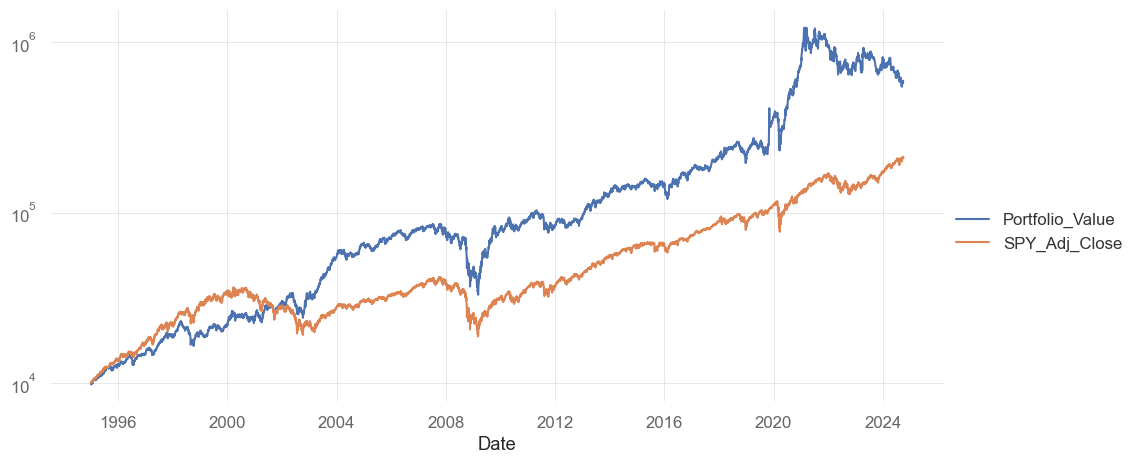

In [28]:
sns.relplot(historical_performance_benchmark.loc[:,['Portfolio_Value','SPY_Adj_Close']], kind='line', dashes=False, aspect=2).set(yscale='log')

In [32]:
historical_performance_benchmark['Portfolio_Returns'] = historical_performance_benchmark['Portfolio_Value'].pct_change()
historical_performance_benchmark['SPY_Returns'] = historical_performance_benchmark['SPY_Adj_Close'].pct_change()
display(historical_performance_benchmark)

C:\Users\matth\AppData\Local\Temp\ipykernel_9804\4183507633.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  historical_performance_benchmark['Portfolio_Returns'] = historical_performance_benchmark['Portfolio_Value'].pct_change()


,Portfolio_Value,SPY_Adj_Close,Portfolio_Returns,SPY_Returns
Date,,,,
1995-01-03,10000.000000,10000.000000,NaN,NaN
1995-01-04,9945.076365,10047.781479,-0.005492,0.004778
1995-01-05,9932.292869,10047.781479,-0.001285,0.000000
1995-01-06,9895.605735,10058.011886,-0.003694,0.001018
1995-01-09,9860.528210,10068.258549,-0.003545,0.001019
...,...,...,...,...
2024-09-25,577814.692237,211227.071431,-0.009773,-0.002206
2024-09-26,590665.336401,212064.513124,0.022240,0.003965
2024-09-27,595145.896816,211756.952101,0.007586,-0.001450


In [36]:
import pandas as pd
import quantstats as qs

def make_stats_dataframe(returns, benchmark_returns, portfolio_name="portfolio", decimals=3):
    """Outputs a DataFrame of statistics for a single portfolio.

    Args:
        returns (dataframe): portfolio; date as the index column, decimal change values from day to day as the value column.
        benchmark_returns (dataframe): benchmark; date as the index column, decimal change values from day to day as the value column.
        portfolio_name (str, optional): Name of the portfolio. Defaults to "portfolio".
        decimals (int, optional): Number of decimal places for the statistics. Defaults to 3.

    Returns:
        pd.DataFrame: DataFrame with a single row of statistics for the portfolio.
    """
    # Create a dictionary to store the statistics
    stats = {}

    # Calculate and store statistics
    stats["Annualized Return (CAGR)"] = round(qs.stats.cagr(returns) * 100, decimals)
    stats["Volatility (Standard Deviation)"] = round(qs.stats.volatility(returns) * 100, decimals)
    stats["Max Drawdown"] = round(qs.stats.max_drawdown(returns) * 100, decimals)
    
    # Alpha and Beta
    greeks = qs.stats.greeks(returns, benchmark_returns)
    stats["Alpha"] = round(greeks['alpha'], decimals)
    stats["Beta"] = round(greeks['beta'], decimals)
    
    # Sharpe and Sortino Ratios
    stats["Sharpe Ratio"] = round(qs.stats.sharpe(returns), decimals)
    stats["Sortino Ratio"] = round(qs.stats.sortino(returns), decimals)
    
    # Convert the stats dictionary to a DataFrame
    stats_df = pd.DataFrame(stats, index=[portfolio_name])
    
    return stats_df


In [39]:
pd.concat([
        make_stats_dataframe(historical_performance_benchmark.loc[:,'Portfolio_Returns'].dropna(),
                     historical_performance_benchmark.loc[:,'SPY_Returns'].dropna() ),
                make_stats_dataframe(historical_performance_benchmark.loc[:,'SPY_Returns'].dropna(),
                     historical_performance_benchmark.loc[:,'SPY_Returns'].dropna() , portfolio_name='SPY')
],axis=0).transpose()

,portfolio,SPY
Annualized Return (CAGR),9.943,7.327
Volatility (Standard Deviation),23.414,19.078
Max Drawdown,-61.620,-55.189
Alpha,0.066,0.000
Beta,0.815,1.000
Sharpe Ratio,0.704,0.633
Sortino Ratio,1.040,0.899
